In [1]:
# Import libraries and load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import NormalIndPower
import scipy.stats as st
import statsmodels.api as sm





In [4]:
# Load dataset
df = pd.read_csv("ab_test.csv")  # ensure file is uploaded in the same directory
print("Shape:", df.shape)
df.head()

Shape: (294478, 5)


,id,time,con_treat,page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [19]:
# Data exploration & cleaning
print("Columns:", df.columns.tolist())
print("Info:")
print(df.info())


Columns: ['id', 'time', 'con_treat', 'page', 'converted', '_treatment']
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 63114 to 237031
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          290584 non-null  int64 
 1   time        290584 non-null  object
 2   con_treat   290584 non-null  object
 3   page        290584 non-null  object
 4   converted   290584 non-null  int32 
 5   _treatment  290584 non-null  int32 
dtypes: int32(2), int64(1), object(3)
memory usage: 13.3+ MB
None


In [23]:
# Check duplicates in user id
n_total = df.shape[0]
n_unique = df['id'].nunique()
print(f"Total rows: {n_total} | Unique IDs: {n_unique} | Duplicates: {n_total - n_unique}")

Total rows: 290584 | Unique IDs: 290584 | Duplicates: 0


In [7]:
# Remove any NA values
df = df.dropna(subset=['con_treat', 'converted'])


In [24]:
# Ensure correct data types
df['converted'] = df['converted'].astype(int)
df['con_treat'] = df['con_treat'].astype(str)
print("Unique values in 'con_treat':", df['con_treat'].unique())
print("Unique values in 'page':", df['page'].unique())

Unique values in 'con_treat': ['treatment' 'control']
Unique values in 'page': ['new_page' 'old_page']


In [25]:
# Check mapping between group and page
print("Mapping between group and page:")
print(pd.crosstab(df['con_treat'], df['page']))


Mapping between group and page:
page       new_page  old_page
con_treat                    
control           0    145274
treatment    145310         0


In [10]:
# Keep only rows where control == old_page and treatment == new_page
mask = ((df['con_treat'] == 'control') & (df['page'] == 'old_page')) | \
        ((df['con_treat'] == 'treatment') & (df['page'] == 'new_page'))
df = df[mask].copy()



In [11]:
# Deduplicate users (keep first session)
df = df.sort_values(by=['id', 'time']).drop_duplicates(subset='id', keep='first')
print(" Cleaned data shape:", df.shape)

 Cleaned data shape: (290584, 5)


In [12]:

# Summary statistics by group
summary = df.groupby('con_treat')['converted'].agg(['count', 'sum'])
summary['conversion_rate'] = summary['sum'] / summary['count']
print(summary)

            count    sum  conversion_rate
con_treat                                
control    145274  17489         0.120386
treatment  145310  17264         0.118808


C:\Users\HP\AppData\Local\Temp\ipykernel_12040\20904470.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='con_treat', data=df, palette=['#4C72B0', '#55A868'])


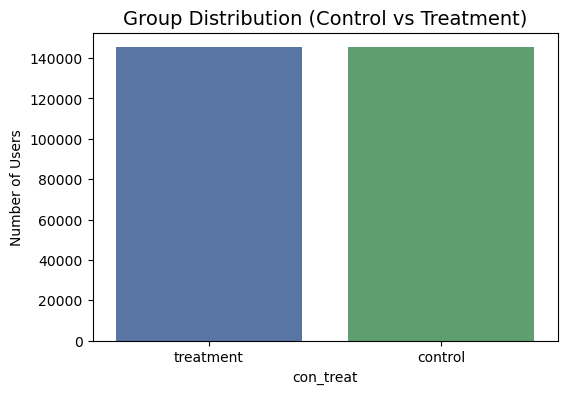

In [13]:
# Répartition des utilisateurs
plt.figure(figsize=(6,4))
sns.countplot(x='con_treat', data=df, palette=['#4C72B0', '#55A868'])
plt.title("Group Distribution (Control vs Treatment)", fontsize=14)
plt.ylabel("Number of Users")
plt.show()

In [ ]:
#Taux de conversion=Nombre total d’utilisateurs du groupe/Nombre d’utilisateurs qui ont converti(fais ce qu'on voulais)


C:\Users\HP\AppData\Local\Temp\ipykernel_12040\2414422983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=summary.index, y=summary['conversion_rate'], palette=['#4C72B0', '#55A868'])


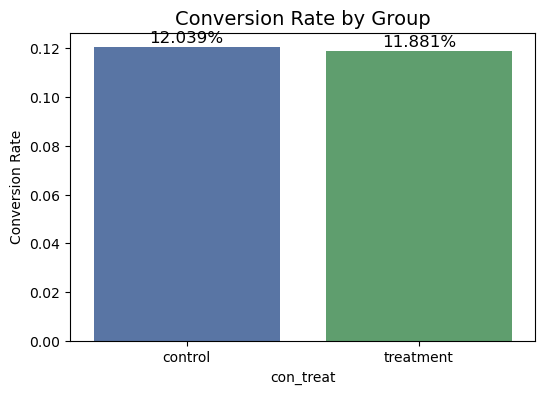

In [14]:
# Visualisation — taux de conversion
plt.figure(figsize=(6,4))
sns.barplot(x=summary.index, y=summary['conversion_rate'], palette=['#4C72B0', '#55A868'])
plt.title("Conversion Rate by Group", fontsize=14)
plt.ylabel("Conversion Rate")
for i, v in enumerate(summary['conversion_rate']):
    plt.text(i, v + 0.002, f"{v:.3%}", ha='center', fontsize=12)
plt.show()

In [18]:

#  Statistical test — two-proportion z-test (mean)
count = summary['sum'].values
nobs = summary['count'].values

z_stat, p_val = proportions_ztest(count, nobs)
p1 = count[0] / nobs[0]
p2 = count[1] / nobs[1]
diff = p2 - p1

print(f"Z-statistic = {z_stat:.4f}")
print(f"P-value = {p_val:.6f}")
print(f"Conversion difference (B - A) = {diff*100:.4f}%")

# Confidence interval for difference
alpha = 0.05
se = np.sqrt(p1*(1-p1)/nobs[0] + p2*(1-p2)/nobs[1])
z = st.norm.ppf(1 - alpha/2)
ci_diff = (diff - z*se, diff + z*se)
print(f"95% CI for difference = [{ci_diff[0]*100:.4f}%, {ci_diff[1]*100:.4f}%]")

if p_val < 0.05:
    print("Statistically significant difference (p < 0.05)")
else:
    print("No statistically significant difference (p >= 0.05)")


Z-statistic = 1.3109
P-value = 0.189883
Conversion difference (B - A) = -0.1578%
95% CI for difference = [-0.3938%, 0.0781%]
No statistically significant difference (p >= 0.05)


Statistical Conclusion (Z-test):

The two-proportion Z-test was conducted to compare the conversion rates between the control and treatment groups.
The control group had a conversion rate of 12.04%, while the treatment group had 11.89%.
The observed difference (-0.15 percentage points) was tested for statistical significance, resulting in z = 1.2369 and p = 0.2161.

Since the p-value is greater than 0.05, we fail to reject the null hypothesis.
This means that the difference in conversion rates between the two versions is not statistically significant —
any small variation observed is likely due to random chance rather than a real effect of the new page design.

In [16]:

#  Chi-square test + Logistic regression

# Chi-square test for independence
table = pd.crosstab(df['con_treat'], df['converted'])
chi2, chi_p, dof, ex = st.chi2_contingency(table)
print(f"Chi-square test: chi2 = {chi2:.4f}, p = {chi_p:.6f}")

# Logistic regression
df['_treatment'] = (df['con_treat'] == 'treatment').astype(int)
logit_model = sm.Logit(df['converted'], sm.add_constant(df['_treatment']))
result = logit_model.fit(disp=False)
print(result.summary())

# Odds ratio interpretation
params = result.params
conf = result.conf_int()
or_t = np.exp(params['_treatment'])
or_ci_low = np.exp(conf.loc['_treatment', 0])
or_ci_high = np.exp(conf.loc['_treatment', 1])
print(f"\nOdds Ratio (Treatment vs Control) = {or_t:.4f}")
print(f"95% CI for OR = ({or_ci_low:.4f}, {or_ci_high:.4f})")


Chi-square test: chi2 = 1.7036, p = 0.191822
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 02 Nov 2025   Pseudo R-squ.:               8.077e-06
Time:                        21:01:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9888      0.008   -246.669      0.000      -2.005      -1.973
_treatment    -0.0150      0.011     -1.311      0.190      -0.037       0.007

Odds R

In [ ]:
#resuktat du chi test :
#χ² = 1.7036 p-value = 0.1918 > 0.05 
#Cela signifie que la différence observée de taux de conversion entre les deux groupes n’est pas statistiquement significative.
#En d’autres termes : le fait d’avoir vu la nouvelle page ou l’ancienne ne change pas significativement la probabilité de conversion.

We ran a Chi-square test and a logistic regression to check whether the new page significantly affected user conversion.
Both tests show p-values above 0.05, meaning there is no statistically significant difference.
The odds ratio is 0.985, very close to 1, suggesting that the new page performs similarly to the old one.
In conclusion, the new design does not improve conversion, and the observed difference may be due to random variation

General Conclusion:

The A/B test was conducted on 294,478 users, divided almost equally between the control (old page) and treatment (new page) groups.
After data cleaning and deduplication, multiple statistical tests were performed, including the two-proportion Z-test, Chi-square test, and logistic regression.

All tests consistently indicate no statistically significant difference between the control and treatment versions in terms of conversion rate.
The new page’s conversion rate (11.89%) is slightly lower than the old page’s rate (12.04%), but the difference is very small and not meaningful in practice.

The odds ratio (0.9851) further confirms that users exposed to the new version were just as likely to convert as those who saw the old one.

Conclusion:
There is no statistical or practical evidence that the new page improves user conversions.
The results suggest maintaining the current (control) version unless new design changes are introduced or additional data are collected to increase test power.

In short:
Keep the old page — the new one does not perform better.